In [57]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import joblib
import itertools
import random

# seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# -------------------------------
# Step 1: Load Data and Artifacts
# -------------------------------
X_train_df = pd.read_csv("preprocessed_data/X_train.csv")
y_train_df = pd.read_csv("preprocessed_data/y_train.csv")

scaler = joblib.load("preprocessed_data/standard_scaler.pkl")
cat_vocab = joblib.load("preprocessed_data/cat_vocab.pkl")
cat_mapping = joblib.load("preprocessed_data/cat_mapping.pkl")
print("Loaded StandardScaler and categorical artifacts.")

# -------------------------------
# Step 2: Define Feature Lists
# -------------------------------
numeric_features = ['amt', 'city_pop', 'age', 'hour', 'day', 'month', 'weekday', 'distance', 'lat', 'long', 'merch_lat', 'merch_long']
cat_features = ['merchant', 'category', 'gender', 'state', 'city', 'job']

# -------------------------------
# Step 3: Filter Data for Fraud Cases and Non-Fraud Cases
# -------------------------------
y_train = y_train_df.iloc[:, 0]
fraud_mask = (y_train == 1)
nonfraud_mask = (y_train == 0)

X_train_num = X_train_df[numeric_features].loc[fraud_mask].values
X_train_cat = X_train_df[cat_features].loc[fraud_mask].values
X_nonfraud_num = X_train_df[numeric_features].loc[nonfraud_mask].values

# -------------------------------
# Step 4: Engineered Features (time features)
# -------------------------------
eng_features = ['hour', 'day', 'month', 'weekday', 'distance']
eng_indices = [numeric_features.index(feat) for feat in eng_features]

eng_min_np = np.min(X_train_num[:, eng_indices], axis=0)
eng_max_np = np.max(X_train_num[:, eng_indices], axis=0)
eng_min = torch.tensor(eng_min_np, dtype=torch.float32)
eng_max = torch.tensor(eng_max_np, dtype=torch.float32)
print("Engineered features - observed min:", eng_min_np, "max:", eng_max_np)

# -------------------------------
# Step 5: Create Dataset and DataLoader
# -------------------------------
class SparkovFraudDataset(Dataset):
    def __init__(self, num_data, cat_data):
        self.num_data = torch.tensor(num_data, dtype=torch.float32)
        self.cat_data = torch.tensor(cat_data, dtype=torch.long)
    def __len__(self):
        return self.num_data.shape[0]
    def __getitem__(self, idx):
        return self.num_data[idx], self.cat_data[idx]

fraud_dataset = SparkovFraudDataset(X_train_num, X_train_cat)
loader = DataLoader(fraud_dataset, batch_size=40, shuffle=True)

# -------------------------------
# Step 6: Set Device and Diffusion Hyperparameters
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

T_train = 800
beta_start = 1e-4
beta_end = 0.02
beta = torch.linspace(beta_start, beta_end, T_train).to(device)
alpha = 1.0 - beta
alpha_hat = torch.cumprod(alpha, dim=0).to(device)

# Compute non-fraud statistics for prior loss
X_nonfraud_tensor = torch.tensor(X_nonfraud_num, dtype=torch.float32).to(device)
mu_nf = X_nonfraud_tensor.mean(dim=0, keepdim=True)
sigma_nf = X_nonfraud_tensor.std(dim=0, keepdim=True) + 1e-5

# Loss weight parameters
#w1 = 0.2
#w2 = 0.6

# -------------------------------
# Step 7: Define Loss Functions and Forward Diffusion
# -------------------------------
def forward_diffusion(x0, t):
    sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)
    sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
    noise = torch.randn_like(x0).to(device)
    x_t = sqrt_alpha_hat_t * x0 + sqrt_one_minus_alpha_hat_t * noise
    return x_t, noise

def compute_Lnorm(pred_noise, true_noise):
    return F.mse_loss(pred_noise, true_noise)

def compute_Lprior(pred_noise):
    z = (pred_noise - mu_nf) / sigma_nf
    z_abs = torch.abs(z)
    normal = torch.distributions.Normal(0, 1)
    prob = 1 - normal.cdf(z_abs)
    L_prior = 1 - 2 * prob
    return L_prior.mean()

def triplet_loss(anchor, positive, negative, margin=1.0):
    pos_distance = F.pairwise_distance(anchor, positive, p=2)
    neg_distance = F.pairwise_distance(anchor, negative, p=2)
    loss = F.relu(pos_distance - neg_distance + margin)
    return loss.mean()

def engineered_range_loss(x0_est_eng, eng_min, eng_max):
    lower_penalty = F.relu(eng_min - x0_est_eng)
    upper_penalty = F.relu(x0_est_eng - eng_max)
    return torch.mean(lower_penalty + upper_penalty)

# -------------------------------
# Step 8: Define the Model (CombinedNoisePredictor)
# -------------------------------
class CombinedNoisePredictor(nn.Module):
    def __init__(self, num_input_dim, cat_vocab_sizes, cat_embed_dim=2, hidden_dim=256):
        super(CombinedNoisePredictor, self).__init__()
        self.embeddings = nn.ModuleDict()
        for col, vocab in cat_vocab_sizes.items():
            self.embeddings[col] = nn.Embedding(vocab, cat_embed_dim)
        cat_total_dim = len(cat_vocab_sizes) * cat_embed_dim
        combined_input_dim = num_input_dim + cat_total_dim
        self.fc1 = nn.Linear(combined_input_dim + 1, hidden_dim)  # +1 for timestep
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, combined_input_dim)
        self.activation = nn.LeakyReLU()
        
    def forward(self, x_num, x_cat, t):
        embeds = []
        for i, col in enumerate(self.embeddings):
            emb = self.embeddings[col](x_cat[:, i])
            embeds.append(emb)
        x_cat_emb = torch.cat(embeds, dim=1)
        x = torch.cat([x_num, x_cat_emb], dim=1)
        t_norm = t.unsqueeze(1).float() / T_train
        x_input = torch.cat([x, t_norm], dim=1)
        h = self.activation(self.fc1(x_input))
        h = self.activation(self.fc2(h))
        out = self.fc3(h)
        return out

# -------------------------------
# Step 9: Hyperparameter Search Code Using Your Actual Dataset
# -------------------------------
# Define hyperparameter grid
lr_list = [0.001]
hidden_dims = [256]
cat_embed_dims = [4,8,12,16]
lambda_eng_list = [0.01, 0.05, 0.1]
w1_list = [0.01, 0.1, 0.5]
w2_list = [0.01, 0.1, 0.5]

results = []

for lr, hidden_dim, cat_embed_dim, lambda_eng, w1, w2 in itertools.product(lr_list, hidden_dims, cat_embed_dims, lambda_eng_list, w1_list, w2_list):
    print(f"Testing configuration: lr={lr}, hidden_dim={hidden_dim}, cat_embed_dim={cat_embed_dim}, lambda_eng={lambda_eng}, w1={w1}, w={w2} ")
    
    # Instantiate model with current hyperparameters
    model = CombinedNoisePredictor(
        num_input_dim=len(numeric_features),
        cat_vocab_sizes={col: cat_vocab[col] for col in cat_features},
        cat_embed_dim=cat_embed_dim,
        hidden_dim=hidden_dim
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    num_epochs = 50  # Use fewer epochs for tuning
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch in loader:
            x0_num, x0_cat = batch
            x0_num = x0_num.to(device)
            x0_cat = x0_cat.to(device)
            batch_size = x0_num.shape[0]
            
            # Sample random timesteps for diffusion
            t = torch.randint(0, T_train, (batch_size,), device=device)
            x_t_num, true_noise = forward_diffusion(x0_num, t)
            pred_noise = model(x_t_num, x0_cat, t)
            pred_noise_numeric = pred_noise[:, :len(numeric_features)]
            
            L_norm = compute_Lnorm(pred_noise_numeric, true_noise)
            L_prior = compute_Lprior(pred_noise_numeric)
            
            sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)
            sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
            x0_est = (x_t_num - sqrt_one_minus_alpha_hat_t * pred_noise_numeric) / sqrt_alpha_hat_t
            
            neg_indices = torch.randint(0, X_nonfraud_tensor.shape[0], (batch_size,), device=device)
            negative_sample = X_nonfraud_tensor[neg_indices]
            L_triplet = triplet_loss(x0_est, x0_num, negative_sample)
            
            # Engineered range loss for engineered features (hour, day, month, weekday)
            x0_est_eng = x0_est[:, eng_indices]
            L_eng = engineered_range_loss(x0_est_eng, eng_min.to(device), eng_max.to(device))
            
            total_loss = L_norm + w1 * L_prior + w2 * L_triplet + lambda_eng * L_eng
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            epoch_loss += total_loss.item()
        
        avg_loss = epoch_loss / len(loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
    results.append({
        'lr': lr,
        'hidden_dim': hidden_dim,
        'cat_embed_dim': cat_embed_dim,
        'lambda_eng': lambda_eng,
        'avg_loss': avg_loss,
        'w1': w1,
        'w2': w2
    })
    print(f"Configuration avg loss: {avg_loss}\n")

# Sort and print best configuration based on average loss
results = sorted(results, key=lambda x: x['avg_loss'])
print("Best configuration:", results[0])


Loaded StandardScaler and categorical artifacts.
Engineered features - observed min: [-1.87890062 -1.67309039 -1.79624861 -1.3500817  -2.58862707] max: [1.49563575 1.70671805 1.41547433 1.37969415 2.31907895]
Using device: cpu
Testing configuration: lr=0.001, hidden_dim=256, cat_embed_dim=4, lambda_eng=0.01, w1=0.01, w=0.01 
Epoch [1/50], Loss: 0.5180
Epoch [2/50], Loss: 0.3934
Epoch [3/50], Loss: 0.3601
Epoch [4/50], Loss: 0.3345
Epoch [5/50], Loss: 0.3344
Epoch [6/50], Loss: 0.3115
Epoch [7/50], Loss: 0.3005
Epoch [8/50], Loss: 0.2924
Epoch [9/50], Loss: 0.2913
Epoch [10/50], Loss: 0.2849
Epoch [11/50], Loss: 0.2721
Epoch [12/50], Loss: 0.2664
Epoch [13/50], Loss: 0.2647
Epoch [14/50], Loss: 0.2671
Epoch [15/50], Loss: 0.2531
Epoch [16/50], Loss: 0.2523
Epoch [17/50], Loss: 0.2500
Epoch [18/50], Loss: 0.2449
Epoch [19/50], Loss: 0.2432
Epoch [20/50], Loss: 0.2339
Epoch [21/50], Loss: 0.2374
Epoch [22/50], Loss: 0.2338
Epoch [23/50], Loss: 0.2352
Epoch [24/50], Loss: 0.2360
Epoch [25/

In [58]:
for col in ['amt', 'city_pop', 'age', 'hour', 'day', 'month', 'weekday']:
    plt.figure(figsize=(10,4))
    sns.histplot(real_numeric_df[col], color='blue', label='Real Fraud', kde=True, bins=30, stat="density")
    sns.histplot(synthetic_numeric_df[col], color='red', label='Synthetic Fraud', kde=True, bins=30, stat="density")
    plt.legend()
    plt.title(f"Distribution of {col}: Real vs Synthetic Fraud")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.show()

NameError: name 'plt' is not defined

Synthetic numeric samples shape (normalized): torch.Size([1000, 12])
Synthetic categorical samples shape: torch.Size([1000, 6])
Real Fraud Numeric Statistics (Original Scale):
               amt     city_pop          age          hour          day  \
count  6273.000000  6273.000000  6273.000000  6.273000e+03  6273.000000   
mean      5.553833     8.427249    48.933842  1.396126e+01    15.704448   
std       1.627878     2.443052    18.723719  9.707241e+00     8.773403   
min       0.722706     3.178054    14.000000  3.545246e-08     1.000001   
25%       5.479722     6.679599    33.000000  2.000000e+00     8.000000   
50%       5.958528     7.940228    48.000000  2.200000e+01    15.000000   
75%       6.802939     9.893640    61.000000  2.300000e+01    23.000000   
max       7.227692    14.882529    96.000000  2.300000e+01    31.000000   

             month       weekday     distance          lat         long  \
count  6273.000000  6.273000e+03  6273.000000  6273.000000  6273.000000  

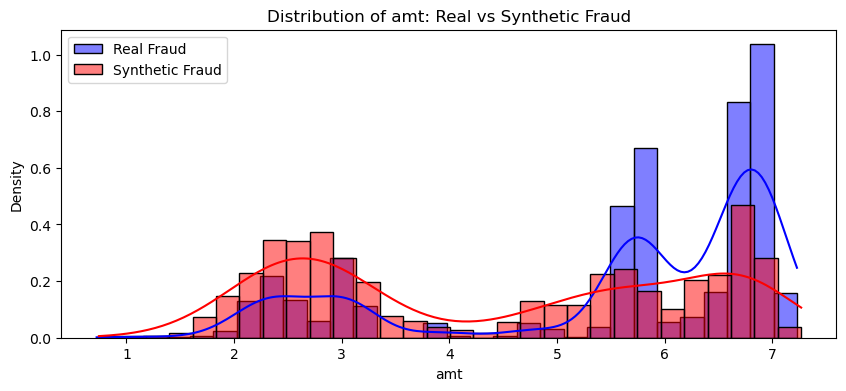

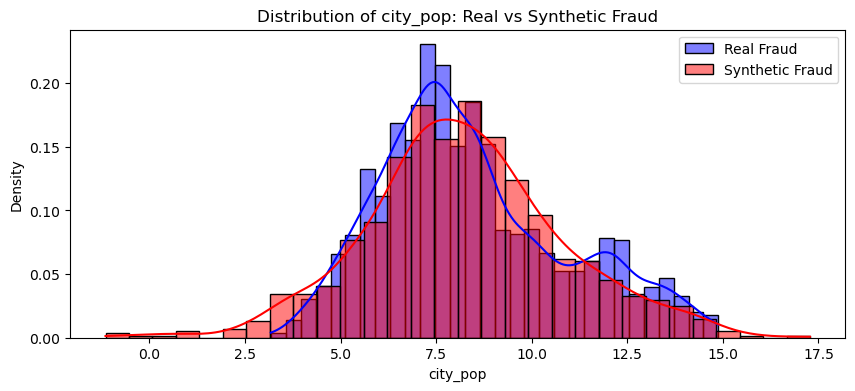

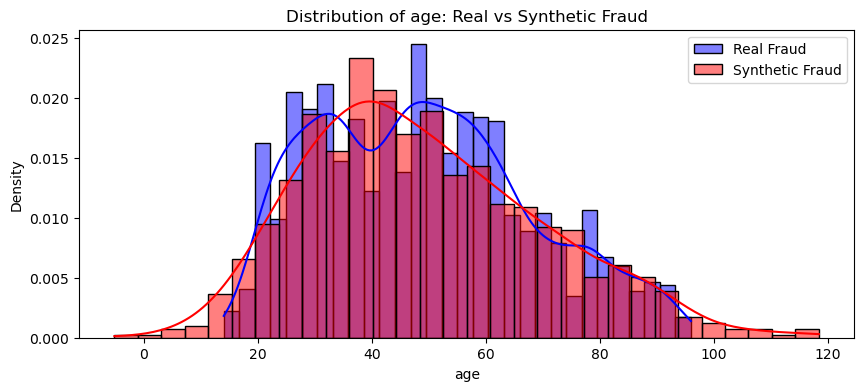

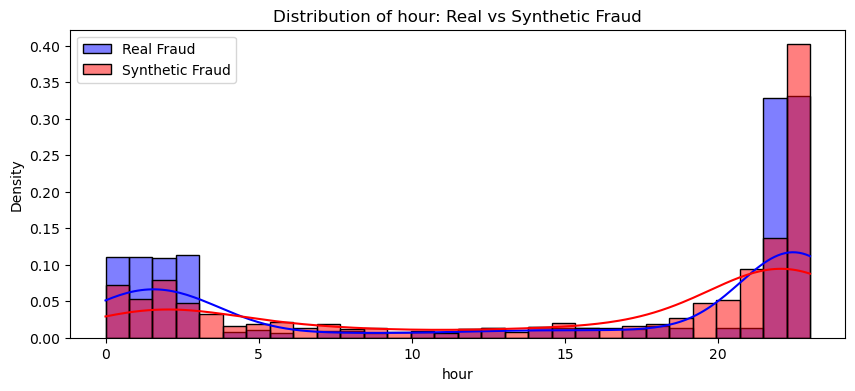

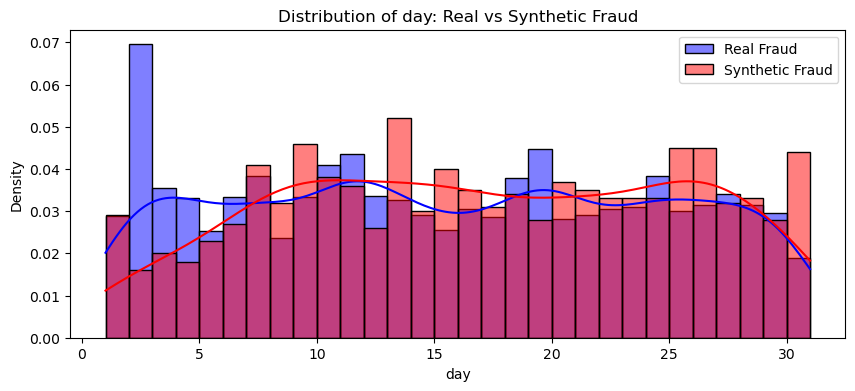

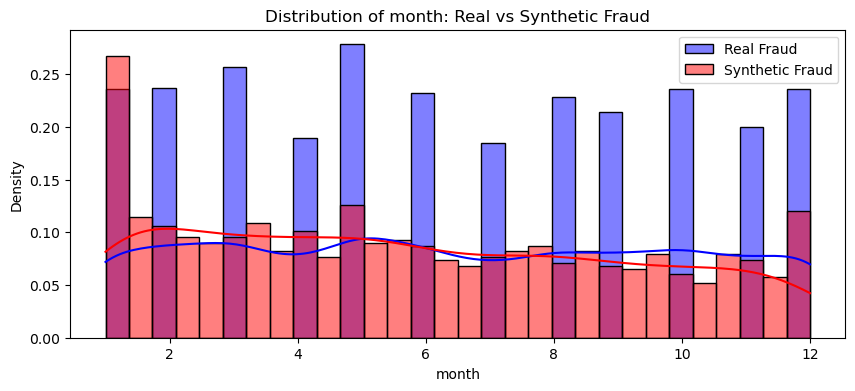

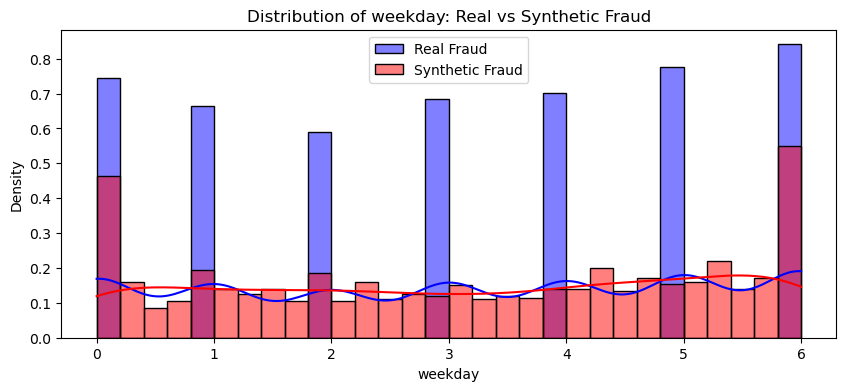

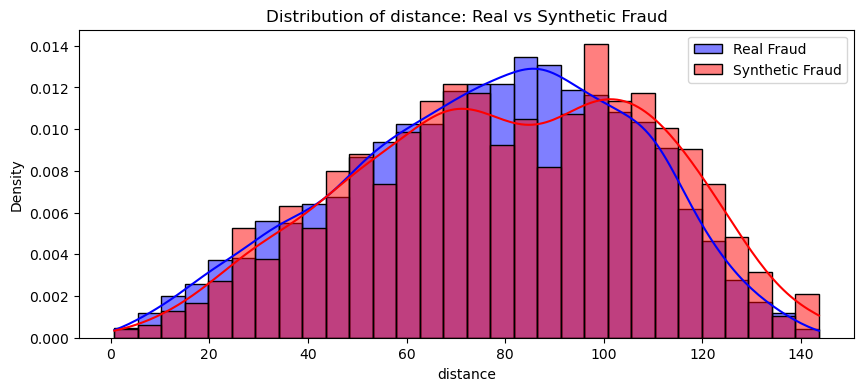

In [ ]:
num_synthetic = 1000
synthetic_num_norm, synthetic_cat = generate_synthetic_fraud(model, num_synthetic)
print("Synthetic numeric samples shape (normalized):", synthetic_num_norm.shape)
print("Synthetic categorical samples shape:", synthetic_cat.shape)

#############################################
# Step 8: Inverse Transform Numeric Features to Original Scale
#############################################
synthetic_num_norm_np = synthetic_num_norm.cpu().numpy()
synthetic_num_original = scaler.inverse_transform(synthetic_num_norm_np)

numeric_features = ['amt', 'city_pop', 'age', 'hour', 'day', 'month', 'weekday', 'distance', 'lat', 'long', 'merch_lat', 'merch_long']

#############################################
# Step 9: Combine Numeric and Categorical Parts and Evaluate
#############################################
synthetic_numeric_df = pd.DataFrame(synthetic_num_original, columns=numeric_features)
synthetic_cat_df = pd.DataFrame(synthetic_cat.cpu().numpy(), columns=cat_features)
synthetic_full_df = pd.concat([synthetic_numeric_df, synthetic_cat_df], axis=1)

X_fraud_tensor = torch.tensor(X_train_num, dtype=torch.float32)
real_numeric = scaler.inverse_transform(X_fraud_tensor.cpu().numpy())
real_numeric_df = pd.DataFrame(real_numeric, columns=numeric_features)

print("Real Fraud Numeric Statistics (Original Scale):")
print(real_numeric_df.describe())
print("\nSynthetic Fraud Numeric Statistics (After Inverse Transform):")
print(synthetic_numeric_df.describe())

for col in ['amt', 'city_pop', 'age', 'hour', 'day', 'month', 'weekday', 'distance']:
    plt.figure(figsize=(10,4))
    sns.histplot(real_numeric_df[col], color='blue', label='Real Fraud', kde=True, bins=30, stat="density")
    sns.histplot(synthetic_numeric_df[col], color='red', label='Synthetic Fraud', kde=True, bins=30, stat="density")
    plt.legend()
    plt.title(f"Distribution of {col}: Real vs Synthetic Fraud")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import wasserstein_distance, ks_2samp
from scipy.spatial.distance import jensenshannon

In [ ]:
numeric_features = ['amt',  'city_pop', 
'age', 'hour', 'day', 'month', 'weekday', 'distance']


Feature: amt
  KS Statistic: 0.3755, p-value: 0.0000
  Wasserstein Distance: 1.1438
  Jensen-Shannon Divergence: 0.3378


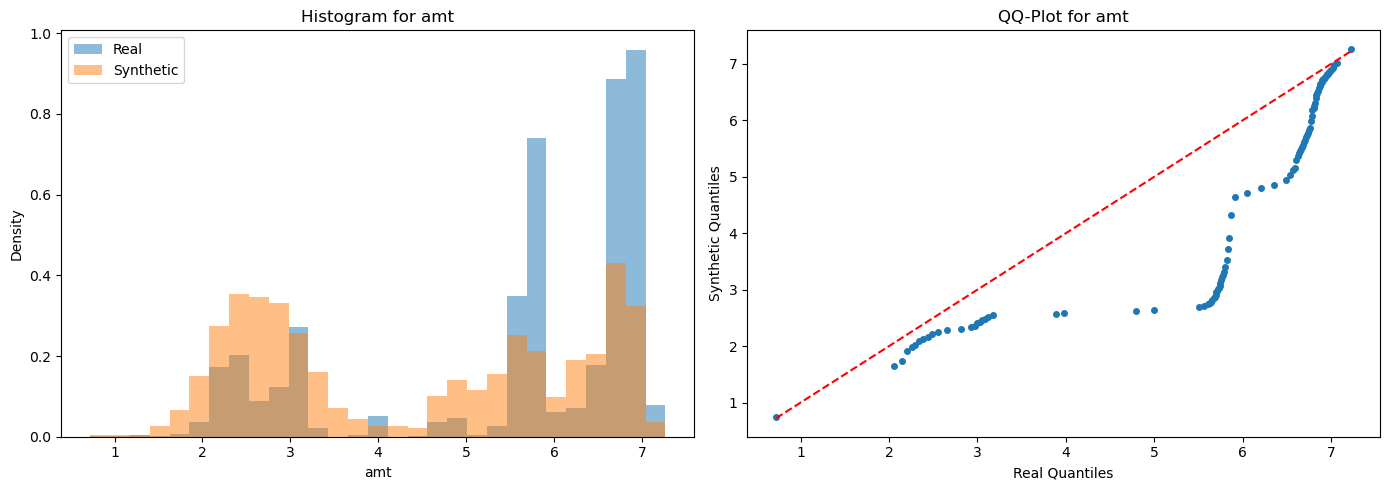


Feature: city_pop
  KS Statistic: 0.0488, p-value: 0.0317
  Wasserstein Distance: 0.2924
  Jensen-Shannon Divergence: 0.1420


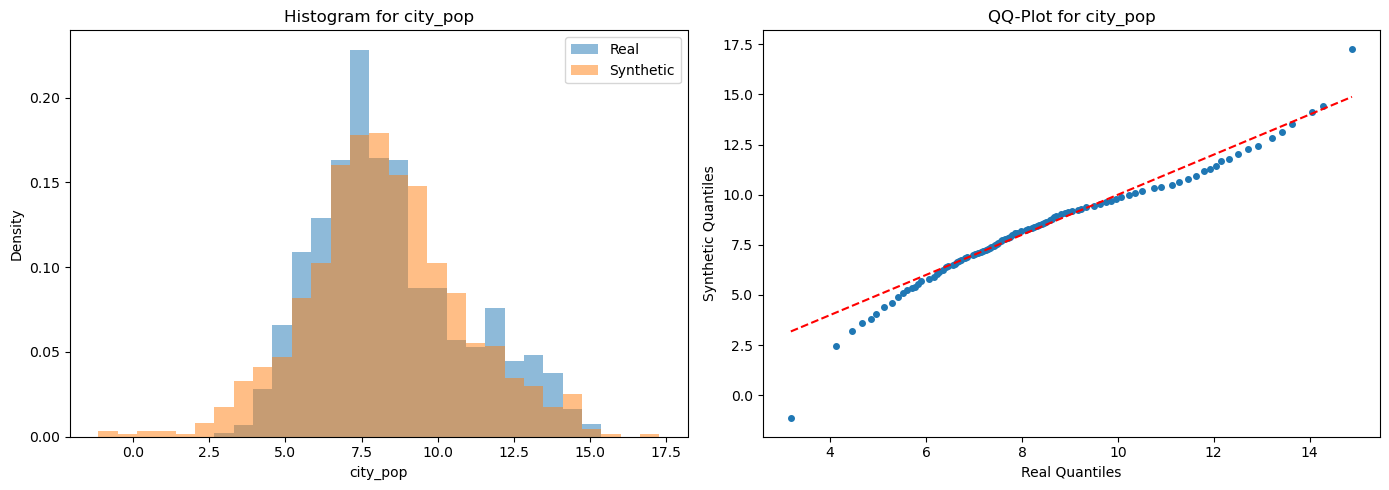


Feature: age
  KS Statistic: 0.0518, p-value: 0.0188
  Wasserstein Distance: 1.7126
  Jensen-Shannon Divergence: 0.1436


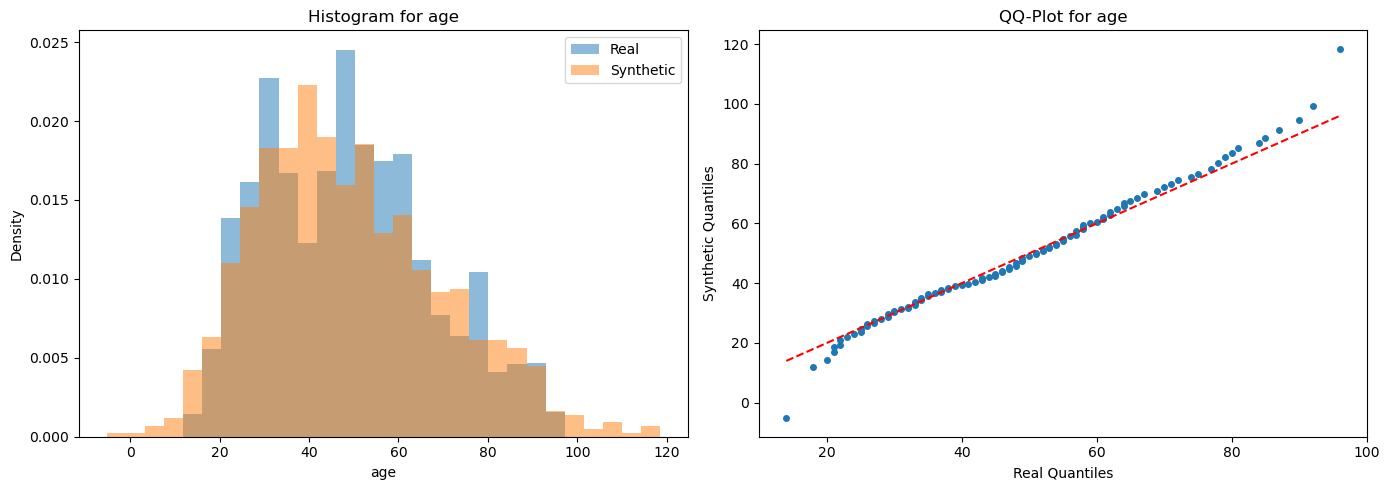


Feature: hour
  KS Statistic: 0.1653, p-value: 0.0000
  Wasserstein Distance: 1.6356
  Jensen-Shannon Divergence: 0.2868


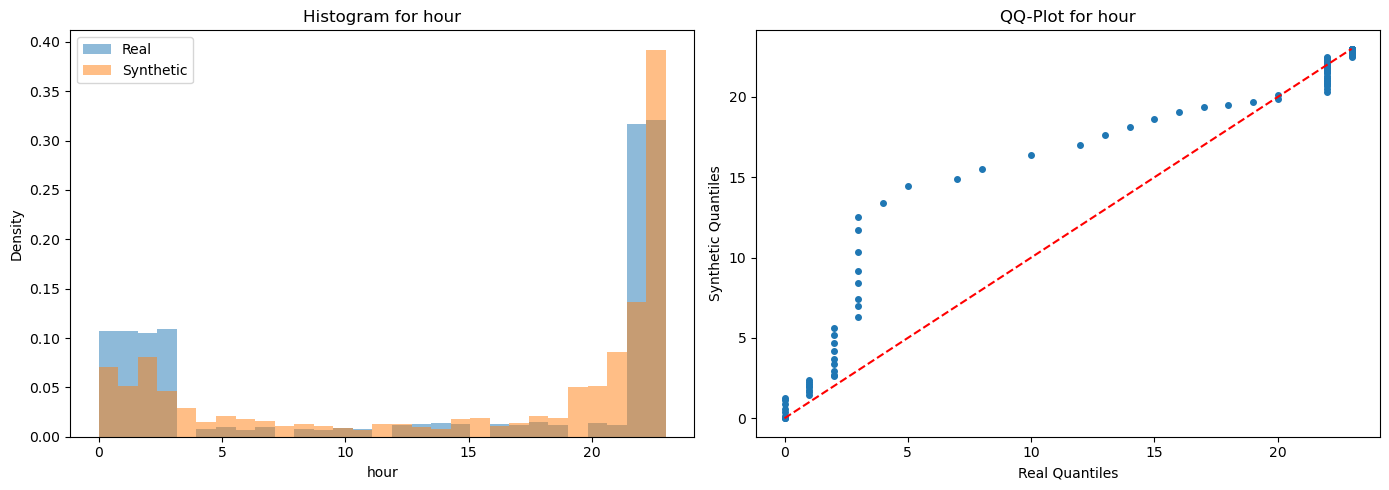


Feature: day
  KS Statistic: 0.0926, p-value: 0.0000
  Wasserstein Distance: 1.2165
  Jensen-Shannon Divergence: 0.1084


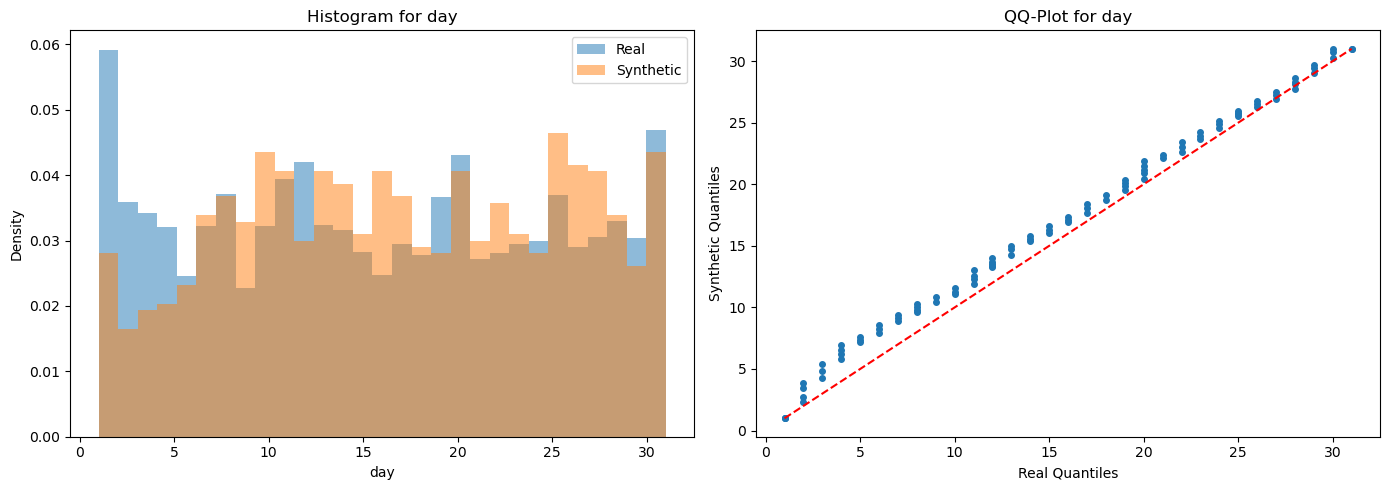


Feature: month
  KS Statistic: 0.1223, p-value: 0.0000
  Wasserstein Distance: 0.6023
  Jensen-Shannon Divergence: 0.4978


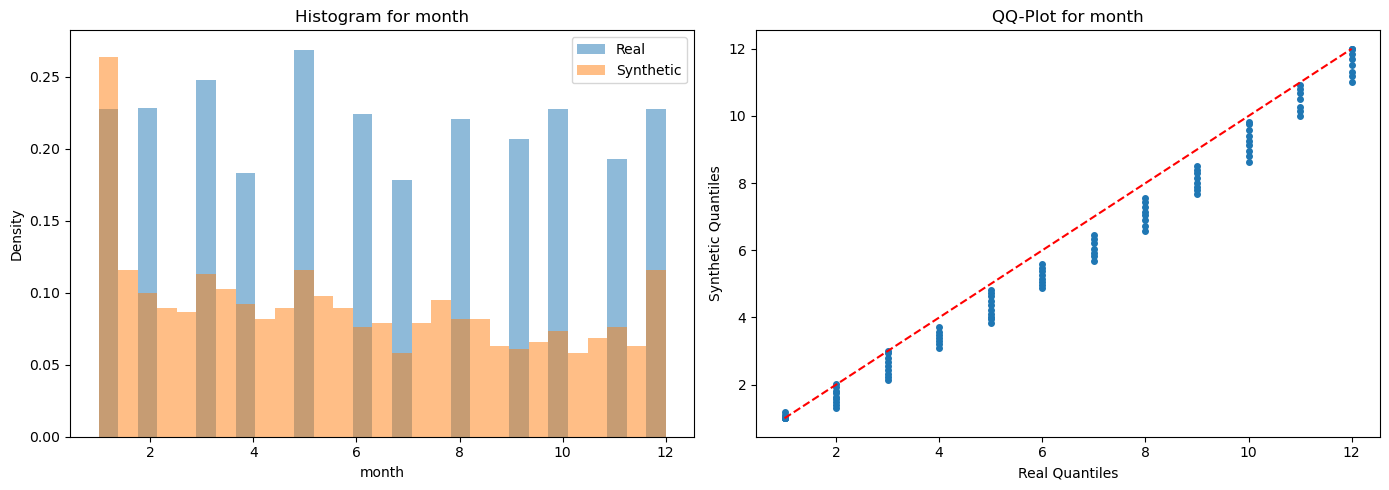


Feature: weekday
  KS Statistic: 0.0847, p-value: 0.0000
  Wasserstein Distance: 0.2116
  Jensen-Shannon Divergence: 0.5611


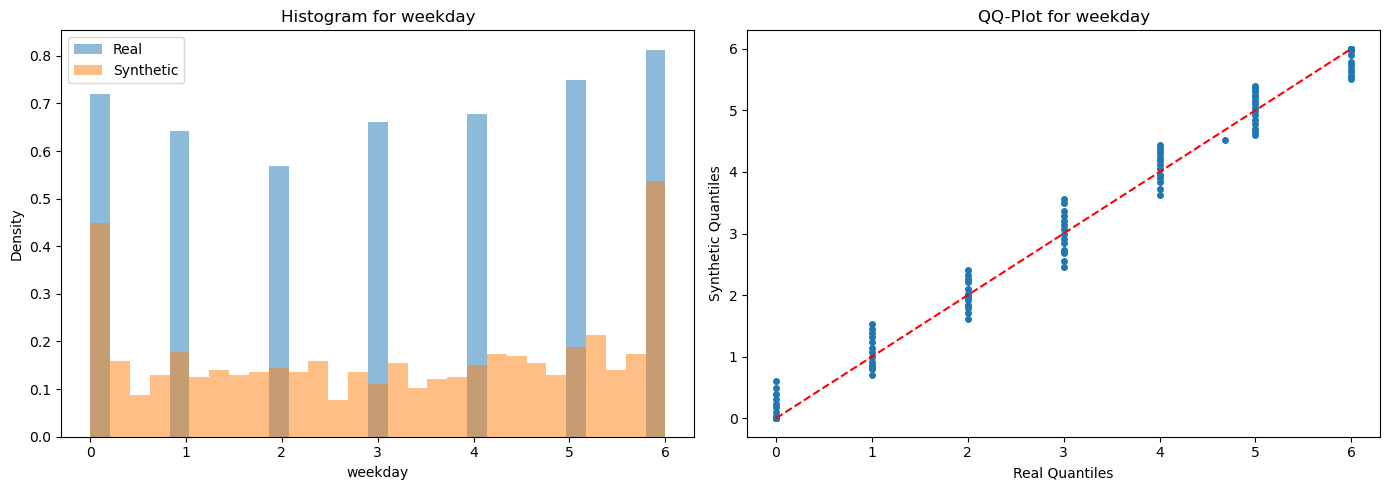


Feature: distance
  KS Statistic: 0.0781, p-value: 0.0001
  Wasserstein Distance: 3.7113
  Jensen-Shannon Divergence: 0.0922


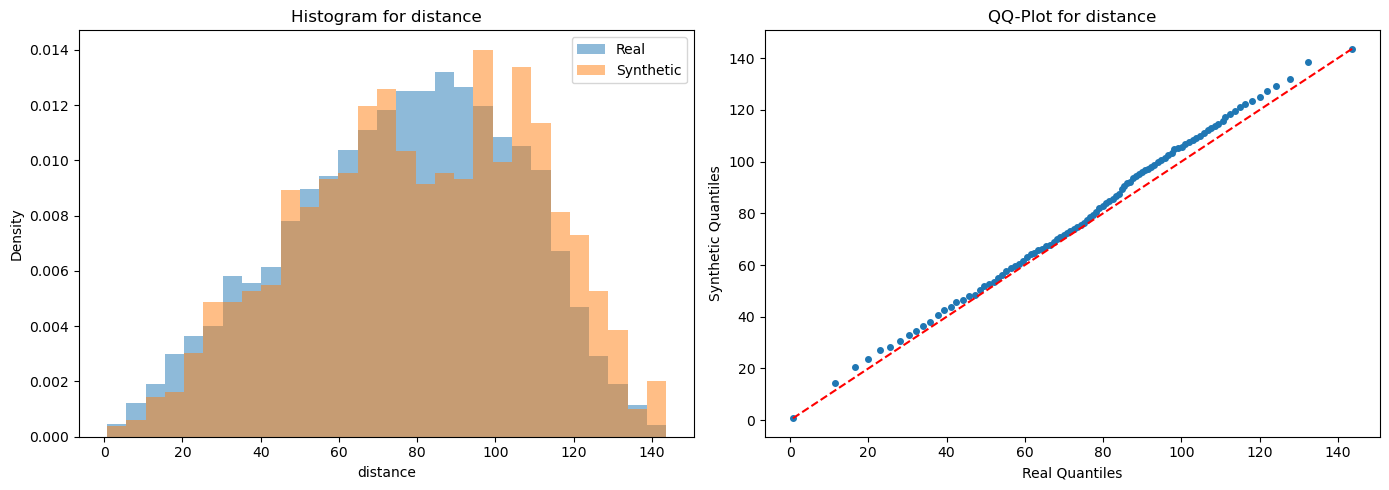

In [ ]:
def compare_distributions(real_numeric_df, synthetic_numeric_df):
    # Loop through each feature to compute statistics and plot comparisons
    for col in numeric_features:
        # Extract data for this feature from both real and synthetic datasets
        real_data = real_numeric_df[col].values
        syn_data = synthetic_numeric_df[col].values
        
        # 1. Kolmogorov–Smirnov test:
        ks_stat, ks_p = ks_2samp(real_data, syn_data)
        
        # 2. Wasserstein distance:
        wass_distance = wasserstein_distance(real_data, syn_data)
        
        # 3. Jensen–Shannon divergence:
        # Define common bins using the min and max of both distributions
        min_val = min(real_data.min(), syn_data.min())
        max_val = max(real_data.max(), syn_data.max())
        bins = np.linspace(min_val, max_val, 30)
        
        # Estimate PDFs (using normalized histograms)
        real_hist, _ = np.histogram(real_data, bins=bins, density=True)
        syn_hist, _ = np.histogram(syn_data, bins=bins, density=True)
        
        # Normalize to form proper probability distributions
        real_pdf = real_hist / real_hist.sum()
        syn_pdf = syn_hist / syn_hist.sum()
        
        jsd = jensenshannon(real_pdf, syn_pdf)

        # Print out the computed metrics for each feature
        print(f"\nFeature: {col}")
        print(f"  KS Statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")
        print(f"  Wasserstein Distance: {wass_distance:.4f}")
        print(f"  Jensen-Shannon Divergence: {jsd:.4f}")

        # Create a figure with two subplots: Histogram and QQ plot
        plt.figure(figsize=(14, 5))

        # Subplot 1: Histogram with density overlay
        plt.subplot(1, 2, 1)
        plt.hist(real_data, bins=bins, alpha=0.5, density=True, label='Real')
        plt.hist(syn_data, bins=bins, alpha=0.5, density=True, label='Synthetic')
        plt.title(f"Histogram for {col}")
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.legend()

        # Subplot 2: QQ-Plot comparing quantiles
        plt.subplot(1, 2, 2)
        quantiles = np.linspace(0, 100, 100)
        real_quantiles = np.percentile(real_data, quantiles)
        syn_quantiles = np.percentile(syn_data, quantiles)
        plt.plot(real_quantiles, syn_quantiles, 'o', markersize=4)
        plt.plot([real_quantiles.min(), real_quantiles.max()],
                 [real_quantiles.min(), real_quantiles.max()], 'r--')
        plt.title(f"QQ-Plot for {col}")
        plt.xlabel("Real Quantiles")
        plt.ylabel("Synthetic Quantiles")
        
        plt.tight_layout()
        plt.show()

compare_distributions(real_numeric_df, synthetic_numeric_df)

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats

def enhanced_statistical_comparison(real_numeric_df, synthetic_numeric_df, numeric_features):
    """
    For each numeric feature, this function computes:
      - Kolmogorov–Smirnov (KS) test statistic and p-value.
      - Anderson–Darling (AD) test statistic and significance level.
      - Skewness and kurtosis for both real and synthetic data.
      
    Parameters:
      real_numeric_df (pd.DataFrame): DataFrame containing real numeric data.
      synthetic_numeric_df (pd.DataFrame): DataFrame containing synthetic numeric data.
      numeric_features (list): List of feature names to compare.
      
    The function prints the statistics for each feature.
    """
    print("Enhanced Statistical Comparison")
    print("=" * 60)
    
    for col in numeric_features:
        # Extract data and remove missing values
        real_data = real_numeric_df[col].dropna().values
        syn_data = synthetic_numeric_df[col].dropna().values
        
        # Kolmogorov–Smirnov test
        ks_stat, ks_p = stats.ks_2samp(real_data, syn_data)
        
        # Anderson–Darling Test (two-sample)
        # anderson_ksamp may throw an exception if both distributions are identical,
        # so we safely wrap it in a try/except block.
        try:
            ad_result = stats.anderson_ksamp([real_data, syn_data])
            ad_stat = ad_result.statistic
            ad_sig = ad_result.significance_level
        except Exception as e:
            ad_stat = np.nan
            ad_sig = np.nan
            print(f"Error in Anderson–Darling test for {col}: {e}")

        # Compute skewness and kurtosis (Fisher's definition, normal distribution => 0 kurtosis)
        real_skew = stats.skew(real_data)
        syn_skew = stats.skew(syn_data)
        real_kurt = stats.kurtosis(real_data)
        syn_kurt = stats.kurtosis(syn_data)
        
        # Display the results
        print(f"\nFeature: {col}")
        print("-" * 60)
        print(f"KS Statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")
        print(f"Anderson–Darling Statistic: {ad_stat:.4f}, significance level: {ad_sig:.4f}")
        print(f"Real Skewness: {real_skew:.4f}, Synthetic Skewness: {syn_skew:.4f}")
        print(f"Real Kurtosis: {real_kurt:.4f}, Synthetic Kurtosis: {syn_kurt:.4f}")
        print("-" * 60)

# Define your list of numeric feature names.
numeric_features = ['amt', 'city_pop', 'merch_lat', 'merch_long', 
                    'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']


if __name__ == "__main__":

    enhanced_statistical_comparison(real_numeric_df, synthetic_numeric_df, numeric_features)

Enhanced Statistical Comparison

Feature: amt
------------------------------------------------------------
KS Statistic: 0.3720, p-value: 0.0000
Anderson–Darling Statistic: 252.3880, significance level: 0.0010
Real Skewness: -1.0827, Synthetic Skewness: 0.0489
Real Kurtosis: -0.3416, Synthetic Kurtosis: -1.6092
------------------------------------------------------------

Feature: city_pop
------------------------------------------------------------
KS Statistic: 0.0703, p-value: 0.0004
Anderson–Darling Statistic: 6.5568, significance level: 0.0010
Real Skewness: 0.5893, Synthetic Skewness: 0.3790
Real Kurtosis: -0.2915, Synthetic Kurtosis: 0.4514
------------------------------------------------------------

Feature: merch_lat
------------------------------------------------------------
KS Statistic: 0.0801, p-value: 0.0000
Anderson–Darling Statistic: 15.9201, significance level: 0.0010
Real Skewness: 0.0380, Synthetic Skewness: -0.1762
Real Kurtosis: 1.7684, Synthetic Kurtosis: 0.8321

C:\Users\Owner\AppData\Local\Temp\ipykernel_22040\835363777.py:34: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_result = stats.anderson_ksamp([real_data, syn_data])
